# Part II - testing ssGMM

* Part I  - estimating missing log values
* **Part II - testing ssGMM**
* Part III - facies classification using ssGMM

**Author: Michael W. Dunham**

**Date: October 25, 2019**

This Jupyter notebook is Part II in a series that focuses on performing an initial test of the ssGMM code on the well log dataset. We begin by first loading the complete dataset from Part I. The second stage is splitting the data into training and test sets as outlined in the C&G publication. Next, we standardize/scale the data using the [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) method.

When applying the ssGMM code to this situation, as noted in Section 4.1 - Initial ssGMM test from the publication, the convergence is poor. I subseqently show that this phenomenon is attributed to the non-marine/marine indicator (NM_M) violating the underlying Gaussian assumption of ssGMM. We then split the dataset into two pieces based on this variable, i.e. the non-marine and marine datasets. The convergence is shown to behave correctly on the two split datasets in comparison to the standard/global dataset.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import sys, sklearn, xgboost, joblib
print('This Jupyter-Notebook has been executed using the following packages/versions:')
print('Python:       ' + sys.version.split('\n')[0])
print('Pandas:       ' + pd.__version__)
print('Numpy:        ' + np.__version__)
print('Matplotlib:   ' + mpl.__version__)
print('Sklearn:      ' + sklearn.__version__)

This Jupyter-Notebook has been executed using the following packages/versions:
Python:       3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas:       0.24.2
Numpy:        1.16.2
Matplotlib:   3.0.3
Sklearn:      0.20.3


# Loading the well log dataset
* This is the dataset created from Part I that has PE values estimated for the KIMZEY and ALEXANDER wells

In [3]:
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'facies_vectors_complete.csv'
all_data = pd.read_csv(filename)
all_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4137.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.758416,1.518679,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.847002,0.499711,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.317000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [4]:
all_data['Well Name'] = all_data['Well Name'].astype('category')
all_data['Formation'] = all_data['Formation'].astype('category')
print("The names of all 10 wells:")
print(all_data['Well Name'].unique())

The names of all 10 wells:
[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]


In [5]:
all_data = all_data.dropna(axis=0)

In [6]:
# This shows that there are 12 points with NaNs that were removed
all_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000
mean,4.490210,2906.492869,65.018896,0.659198,4.396208,13.210462,3.758416,1.517283,0.521791
std,2.466009,133.176827,30.290153,0.252039,5.276518,7.139950,0.847002,0.499762,0.286762
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.940000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,65.107000,0.639000,4.300000,12.036000,3.600000,2.000000,0.527000
75%,6.000000,3006.500000,79.470000,0.822000,7.500000,16.066000,4.317000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## Establish training and testing data
* In accordance with the C&G publication, we only consider one well as training (and the remaining nine wells as testing data) to similate a semi-supervised scenario.

In [7]:
## Isolated ONE well for training
train_data = all_data[(all_data['Well Name'] == 'KIMZEY A')]

## The remaining wells are used for testing
test_data = all_data[all_data['Well Name'] != 'KIMZEY A']

## Standardizing the data
* We consider RobustScaler instead of StandardScaler because there are outliers in the data and scaling based on the 'mean' could skew the data
* We also determine the scaler from *all* the data (i.e. the training and the testing data) and use that scaler on both the training and testing sets

In [8]:
all_data_feature_vectors = all_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
scaler = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit(all_data_feature_vectors)

In [9]:
#Training data
train_data_y = train_data['Facies'].values
train_data_X = train_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
train_data_X = scaler.transform(train_data_X)

#Testing data
test_data_y = test_data['Facies'].values
test_data_X = test_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
test_data_X = scaler.transform(test_data_X)

# Semi-supervised GMM on the global data

In [10]:
########################
### Loading the code ###
########################
import sys
sys.path.append('../ssGMM_code/')
from ssGMM import ss_GaussianMixtureModels

In [11]:
## Training the ssGMM algorithm using default values for beta & tol
ss_GMMresults = ss_GaussianMixtureModels(train_data_X, train_data_y, test_data_X, test_data_y, beta = 0.50, tol = 0.0316, max_iterations = 50, early_stop = 'False')
obj_global_data = ss_GMMresults[2]

Number of labeled data: 439
Number of unlabeled data: 3698
Max number of iterations reached
The number of iterations used:  50
The objective function: 
 [-25348.535291136854, -11948.594886260049, -11477.081086070812, -10486.43698469913, -10836.434775900834, -10500.208015019625, -11852.389628888026, -7504.983849041726, -7765.612508194832, -12042.45326905249, -4232.986825945657, -7756.644121056518, -11044.997782468798, 362.52578757061224, -8640.786133541076, -11254.678679077953, -9810.366590946222, -10302.291837966179, -11258.413658161431, -5401.852708068183, -10130.599914314364, -11607.408536929059, -7439.745159242911, -9807.09828265098, -4992.451785775957, -6315.695681753388, -11046.996516435125, -11368.15323832743, -7221.222694417086, -8631.887021370589, -9412.0535779152, -4557.604328031628, -6253.366782175773, -10643.155716222056, -11540.580740612264, -8113.316693381768, -9674.27967578287, -10860.419256553945, -9496.542279775089, -9878.337383391141, -10210.247305751665, -9133.0395519

# Splitting the data based on the NM_M indicator

* The objective function for ssGMM clearly does not converge (see above), and the underlying reason why is the NM_M indicator is a binary variable that violates the inherent Gaussian assumption for ssGMM

* The solution (as discussed in Section 4.1 of our paper) is to break the dataset into two separate datasets based on the NM_M indicator.

### Non-marine data (NM_M = 1)
* We filter the dataset by the NM_M value of 1 and this gives us all the data that corresponds to NM = 1
* There is a strong correlation (~99%) between NM = 1 and non-marine facies (Classes 1-3), but this relationship is not perfect due to human error near the interfaces of different classes (i.e. the 31 points belonging to Classes 4-8).

In [12]:
filter1 = all_data['NM_M'] == 1
NM_data = all_data[filter1]
NM_data['Facies'].value_counts()

2    934
3    764
1    268
8     12
5     11
4      5
6      2
7      1
Name: Facies, dtype: int64

In [13]:
## Isolating KIMZEY well for training
NM_train_data = NM_data[(NM_data['Well Name'] == 'KIMZEY A')]

## The remaining wells are used for testing
NM_test_data = NM_data[NM_data['Well Name'] != 'KIMZEY A']

In [14]:
## We use an individual scalar for the non-marine and marine datasets
NM_data_X = NM_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
scaler_NM = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit(NM_data_X)

#Training data
NM_train_data_y = NM_train_data['Facies'].values
NM_train_data_X = NM_train_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
NM_train_data_X = scaler_NM.transform(NM_train_data_X) # Local scaler

#Testing data
NM_test_data_y = NM_test_data['Facies'].values
NM_test_data_X = NM_test_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
NM_test_data_X = scaler_NM.transform(NM_test_data_X) # Local scaler

### Marine data (NM_M = 2)
* We filter the dataset by the NM_M value of 2 and this gives us all the data that corresponds to NM = 2
* There is a strong correlation (~99%) between M = 2 and marine facies (Classes 4-9), but this relationship is not perfect due to human error near the interfaces of different classes (i.e. the 22 points beloning to Classes 2 and 3).

In [15]:
filter2 = all_data['NM_M'] == 2
M_data = all_data[filter2]
M_data['Facies'].value_counts()

8    674
6    580
5    285
4    266
9    173
7    140
3     16
2      6
Name: Facies, dtype: int64

In [16]:
## Isolating KIMZEY well for training
M_train_data = M_data[(M_data['Well Name'] == 'KIMZEY A')]

## The remaining wells are used for testing
M_test_data = M_data[M_data['Well Name'] != 'KIMZEY A']

In [17]:
M_data_X = M_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
scaler_M = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit(M_data_X)

#Training data
M_train_data_y = M_train_data['Facies'].values
M_train_data_X = M_train_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
M_train_data_X = scaler_M.transform(M_train_data_X) #local

#Testing data
M_test_data_y = M_test_data['Facies'].values
M_test_data_X = M_test_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M'], axis=1)
M_test_data_X = scaler_M.transform(M_test_data_X) #local

### Applying the ssGMM code to the two split datasets
* With the 'global' dataset decomposed into non-marine and marine datasets, the NM_M indicator has been removed and we can test to determine if this variable was indeed causing the ssGMM algorithm to not converge

In [18]:
ss_GMMresults_NM = ss_GaussianMixtureModels(NM_train_data_X, NM_train_data_y, NM_test_data_X, NM_test_data_y, beta = 0.50, tol = 0.0316, max_iterations = 50, early_stop = 'False')
obj_NM_data = ss_GMMresults_NM[2]

ss_GMMresults_M = ss_GaussianMixtureModels(M_train_data_X, M_train_data_y, M_test_data_X, M_test_data_y, beta = 0.50, tol = 0.0316, max_iterations = 50, early_stop = 'False')
obj_M_data = ss_GMMresults_M[2]

Number of labeled data: 168
Number of unlabeled data: 1829
The number of iterations used:  15
The objective function: 
 [-14806.581785147337, -6371.418166710952, -6238.350118772762, -6156.968232087986, -6118.682151805597, -6098.068576541428, -6083.525089951674, -6071.767157472279, -6061.361680449171, -6050.920623135684, -6037.185021484495, -6008.731995101003, -5962.587530776376, -5938.846548386852, -5929.885210010688, -5928.139556093332]
Standard accuracy metric of Semi-supervised GMM using beta = 0.5, and tol = 0.0316: 0.5549480590486605
Number of misclassified points: 814/1829

Number of labeled data: 271
Number of unlabeled data: 1869
The number of iterations used:  17
The objective function: 
 [-12821.455572611725, -6846.006385600426, -6769.833862661827, -6727.865646962988, -6694.935051796725, -6675.59633296331, -6658.268289396091, -6647.252871522457, -6641.122709311554, -6637.1056606148595, -6633.881405379947, -6631.061018335223, -6628.50506397316, -6626.170968789268, -6623.982485

# Plotting the objective function values
* The figure below plots the ssGMM objective function values when trained on the global data, and also the split non-marine and marine data.
* Clearly, splitting the NM_M indicator is the underlying cause for causing the ssGMM method to not converge because the objective function for the split datasets behaves and converges very well.
* The Figure below is Figure 4 in the C&G publication.
* **This data decomposition procedure is used for the subsequent results in the Part III Jupyter-notebook**

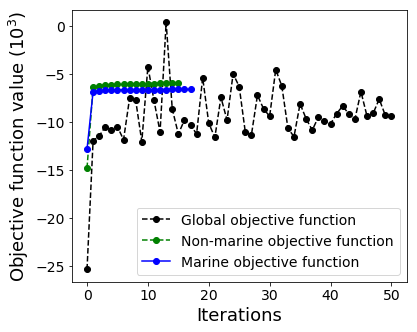

In [21]:
plt.plot(np.linspace(0, len(obj_global_data) - 1, len(obj_global_data)), np.array(obj_global_data)/1000, 'ko--', label="Global objective function")
plt.plot(np.linspace(0, len(obj_NM_data) - 1, len(obj_NM_data)), np.array(obj_NM_data)/1000, 'go--', label="Non-marine objective function")
plt.plot(np.linspace(0, len(obj_M_data) - 1, len(obj_M_data)), np.array(obj_M_data)/1000, 'bo-', label="Marine objective function")

plt.xlabel("Iterations", fontsize = 18)
plt.ylabel("Objective function value ($10^{3}$)", fontsize = 18)
plt.tick_params(labelsize = 14)
plt.rcParams["figure.figsize"] = [6,5]
plt.legend(fontsize = 14)
#plt.savefig("Figures/Figure4.png",bbox_inches="tight", dpi = 600)
plt.show()